In [1]:
# general options
reduceOnGPU = True # do the sum of all logL on GPU instead of CPU (only in the GPU methods, of course)
doCPULoop = False # run and plot the loop method as well (slowest method by far)
usePyCuda = False # instead of numba (Note: both packages cannot be initialized at the same time!)
calculationsPerPyCudaThread = 1000 # only used if usePyCuda = True
float_precision = 64 # 32 or 64; Note: pycuda does not support float64 but float32 is not really precise enough

In [2]:
# monte carlo options
timeConstant = 50 # [GeV] lambda of the exponential background
sigMean = timeConstant*2 # mean of the gaussian signal
sigSigma = timeConstant/5. # width of the gaussian signal
nMCbkg = int(1e8) # number of background events
nMCsig = int(1e7) # number of signal events
histRange = timeConstant*5 # last bin of the histogram

In [3]:
# basic setup and imports
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from math import log, factorial
from iminuit import Minuit
import time
import sys
from IPython.display import clear_output

In [4]:
# pyopencl imports
import pyopencl
import pyopencl.array
import pyopencl.clmath
openClContext = pyopencl.create_some_context()
openClQueue = pyopencl.CommandQueue(openClContext)

In [5]:
# pycuda or numba imports
if usePyCuda:
    import pycuda.driver as cuda
    import pycuda.autoinit
    from pycuda.compiler import SourceModule
    import pycuda.gpuarray
    
else: # use numba instead of pycuda
    from numba import cuda, vectorize, guvectorize
    from numba import void, uint8 , uint32, uint64, int32, int64, float32, float64, f8
    device = cuda.get_current_device()

In [6]:
# generate and histogram data and model
def generateMC(signalStrength=1.):
    mcBkg = np.random.exponential(timeConstant, nMCbkg)
    mcSig = np.random.normal(sigMean, sigSigma, int(nMCsig*signalStrength))
    mcAll = np.concatenate((mcSig, mcBkg), axis=0)
    return mcBkg, mcSig, mcAll

def binMC(nBins=1000):

    binContentAllData, bins = np.histogram(mcAllData, bins=np.arange(0., histRange, histRange/(nBins+1)), density=False)
    
    binContentSigModel, bins = np.histogram(mcSigModel, bins=np.arange(0., histRange, histRange/(nBins+1)), density=False)
    binContentBkgModel, bins = np.histogram(mcBkgModel, bins=np.arange(0., histRange, histRange/(nBins+1)), density=False)
    binContentAllModel, bins = np.histogram(mcAllModel, bins=np.arange(0., histRange, histRange/(nBins+1)), density=False)

    binCenter = (bins[:-1] + bins[1:]) / 2

    return binCenter, binContentAllData, binContentSigModel, binContentBkgModel, binContentAllModel

def plotDataAndModel(bins, data, model, bkg):
   
    binWidth = (bins[1] - bins[0])

    plt.xlabel('m [GeV]')
    plt.ylabel('events')

    plt.plot(bins, data, '.', color='black', label='data')  
    plt.bar(bins, model, align='center', width=binWidth, color='red', label='model sig')    
    plt.bar(bins, bkg, align='center', width=binWidth, color='green', label='model bkg') 
        
    plt.legend()

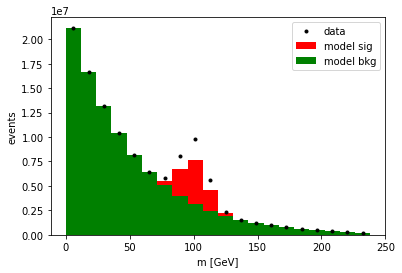

In [7]:
# show example plot of data & model
mcBkgModel, mcSigModel, mcAllModel = generateMC(1.)
_,          _,          mcAllData  = generateMC(1.5)

bins, data, sig, bkg, model = binMC(20)

plotDataAndModel(bins, data, model, bkg)

In [8]:
# get the block and grid size for pycuda (could still be optimised)
if usePyCuda:
    maxBlockSize = 2**10

    def getBlockAndGridSize(vector):
        
        nThreads = len(vector) // calculationsPerPyCudaThread + 1
    
        if nThreads < maxBlockSize:
            blockSize = nThreads
        else:
            blockSize = maxBlockSize
            
        gridSize = (nThreads + blockSize - 1) // blockSize
    
        return blockSize, gridSize

    print(getBlockAndGridSize(data))

To do: use the [cuda occupancy calculator spread sheed](https://docs.nvidia.com/cuda/cuda-occupancy-calculator/index.html) or [these slides](https://www.nvidia.com/content/gtc-2010/pdfs/2238_gtc2010.pdf) to achieve better occupancy than with this function:

In [9]:
# define the right float precision according to the given option
float_type = None
if float_precision == 32:
    float_type = np.float32
if float_precision == 64:
    float_type = np.float64

In [10]:
# define lists to save results

doTiming = False

nBins = []

timeCPUloop = []
timeCPUnumpy = []
timeGPUopencl = []
timeGPUcuda = []

#timeInSumCPUloop = [] #not applicable for loop
timeInSumCPUnumpy = []
timeInSumGPUopencl = []
timeInSumGPUcuda = []

timeInUploadGPUopencl = []
timeInMaskingGPUopencl = []
timeInCalculationGPUopencl = []

timeInVecCPUloop = []
timeInVecCPUnumpy = []
timeInVecGPUopencl = []
timeInVecGPUcuda = []

resultCPUloop = []
resultCPUnumpy = []
resultGPUopencl = []
resultGPUcuda = []

uncertaintyCPUloop = []
uncertaintyCPUnumpy = []
uncertaintyGPUopencl = []
uncertaintyGPUcuda = []

if usePyCuda:
    blockSizeGPU = []
    gridSizeGPU = []

In [11]:
# -2.* binned log likelihood (Poission of each bin, no uncertainties considered) on CPU
def negLogLikelihoodCPUloop(mu):
    if float_precision == 32:  logL = np.float32(0.)
    if float_precision == 64:  logL = np.float64(0.)
    mu = float_type(mu)
    for i, _ in enumerate(data):
        if float_precision == 32:
            N_obs = np.float32(data[i])
            N_sig = np.float32(sig[i])
            N_bkg = np.float32(bkg[i])
        if float_precision == 64:
            N_obs = np.float64(data[i])
            N_sig = np.float64(sig[i])
            N_bkg = np.float64(bkg[i])
        
        if mu*N_sig + N_bkg <= 0.: continue
        logL += N_obs*log(mu*N_sig + N_bkg) - mu*N_sig - N_bkg
    return -2.*logL

In [12]:
# same but using numpy (CPU)
def negLogLikelihoodCPUnumpy(mu):
    N_obs = data.astype(float_type)
    N_sig = sig.astype(float_type)
    N_bkg = bkg.astype(float_type)

    logL = N_obs*np.ma.log(mu*N_sig + N_bkg) - mu*N_sig - N_bkg

    startSum = time.time()
    logLSum = np.sum(logL)
    endSum = time.time()
    if doTiming: timeInSumCPUnumpy[-1] += (endSum - startSum)
    
    return -2.*logLSum

In [13]:
# same but using pyopencl (GPU)

cl_N_obs = None
cl_N_sig = None
cl_N_bkg = None
cl_ones = None

def uploadDataGPUopencl():
    
    global cl_N_obs
    global cl_N_sig
    global cl_N_bkg
    global cl_ones
        
    startUpload = time.time()
    cl_N_obs = pyopencl.array.to_device(openClQueue, data.astype(float_type))
    cl_N_sig = pyopencl.array.to_device(openClQueue, sig.astype(float_type))
    cl_N_bkg = pyopencl.array.to_device(openClQueue, bkg.astype(float_type))
    cl_ones = pyopencl.array.to_device(openClQueue, np.ones_like(data).astype(float_type))
    endUpload = time.time()
    
    if doTiming: timeInUploadGPUopencl[-1] += (endUpload - startUpload)

def negLogLikelihoodGPUopencl(mu):

    global cl_N_obs
    global cl_N_sig
    global cl_N_bkg
    global cl_ones
    
    startCalculation1 = time.time()
    cl_arg_of_log = mu*cl_N_sig + cl_N_bkg
    endCalculation1 = time.time()

    startMasking = time.time()
    cl_arg_of_log_masked = pyopencl.array.if_positive(cl_arg_of_log, cl_arg_of_log, cl_ones)
    endMasking = time.time()

    startCalculation2 = time.time()
    cl_logL = cl_N_obs*pyopencl.clmath.log(cl_arg_of_log_masked, openClQueue) - mu*cl_N_sig - cl_N_bkg
    endCalculation2 = time.time()

    startSum = time.time()
    if reduceOnGPU:
        logLSum = pyopencl.array.sum(cl_logL).get()
    else:
        logLSum = sum(cl_logL.get())
    endSum = time.time()
    
    if doTiming: timeInSumGPUopencl[-1] += (endSum - startSum)
    if doTiming: timeInMaskingGPUopencl[-1] += (endMasking - startMasking)
    if doTiming: timeInCalculationGPUopencl[-1] += (endCalculation1 - startCalculation1 + endCalculation2 - startCalculation2)
        
    return -2.*logLSum

In [14]:
# same but using pycuda
if usePyCuda: #use pycuda instead of numba

    codeOnGPU = pycuda.compiler.SourceModule("""
        __global__ void negLogLikelihood(int *n, int *nT, float *logL, float *N_obs, float *N_sig, float *N_bkg, float *mu){

            int iStart = nT[0]*(blockIdx.x*blockDim.x + threadIdx.x);

            for(int i = iStart; i < iStart + nT[0]; i++){
                if(i < n[0]){

                    if(mu[0]*N_sig[i] + N_bkg[i] > 0){
                        logL[i] = N_obs[i]*log(mu[0]*N_sig[i] + N_bkg[i]) - mu[0]*N_sig[i] - N_bkg[i];  
                    }
                    else{
                        logL[i] = 0.;
                    }
                }
                else{
                    break;
                }
            }
        }
        """)
    
    def uploadDataGPUcuda():
        
        n_i= np.int32(len(data))
        n_gpu = cuda.mem_alloc(n_i.nbytes)
        cuda.memcpy_htod(n_gpu, n_i)

        nT_i= np.int32(calculationsPerPyCudaThread)
        nT_gpu = cuda.mem_alloc(nT_i.nbytes)
        cuda.memcpy_htod(nT_gpu, nT_i)

        N_obs_fl = data.astype(float_type)
        N_obs_gpu = cuda.mem_alloc(N_obs_fl.nbytes)
        cuda.memcpy_htod(N_obs_gpu, N_obs_fl)

        N_sig_fl = sig.astype(float_type)
        N_sig_gpu = cuda.mem_alloc(N_sig_fl.nbytes)
        cuda.memcpy_htod(N_sig_gpu, N_sig_fl)

        N_bkg_fl = bkg.astype(float_type)
        N_bkg_gpu = cuda.mem_alloc(N_bkg_fl.nbytes)
        cuda.memcpy_htod(N_bkg_gpu, N_bkg_fl)
        
    def negLogLikelihoodGPUcuda(mu):    
        
        blockSize, gridSize = getBlockAndGridSize(data)

        logL = np.zeros_like(N_obs_fl)
        logL_fl = logL.astype(float_type)
        logL_gpu = cuda.mem_alloc(logL_fl.nbytes)
        cuda.memcpy_htod(logL_gpu, logL_fl)

        if float_precision == 32:
            mu_fl = np.float32(mu)
        if float_precision == 64:
            mu_fl = np.float64(mu)
        mu_gpu = cuda.mem_alloc(mu_fl.nbytes)
        cuda.memcpy_htod(mu_gpu, mu_fl)

        runOnGPU = codeOnGPU.get_function("negLogLikelihood")
        runOnGPU(n_gpu, nT_gpu, logL_gpu, N_obs_gpu, N_sig_gpu, N_bkg_gpu, mu_gpu, block=(blockSize,1,1), grid=(gridSize,1))
        
        startSum = time.time()
        if reduceOnGPU: # TODO: do this with pycuda instead of pyopencl?
            cuda.memcpy_dtoh(logL, logL_gpu)
            cl_logL = pyopencl.array.to_device(openClQueue, logL.astype(float_type))
            logLSum = pyopencl.array.sum(cl_logL).get()
        else:
            logLSum = sum(cl_logL.get())
        endSum = time.time()
        if doTiming: timeInSumGPUcuda[-1] += (endSum - startSum)
        
        return -2.*logLSum

In [15]:
# same but using numba
if not usePyCuda: #use numba instead of pycuda

    @vectorize(['float'+str(float_precision)+'(float'+str(float_precision)+', float'+str(float_precision)+', float'+str(float_precision)+', float'+str(float_precision)+')'], target='cuda')
    def numbaLogL(N_obs, N_sig, N_bkg, mu):
        if mu*N_sig + N_bkg <= 0. : return 0.
        return N_obs*log(mu*N_sig + N_bkg) - mu*N_sig - N_bkg

    @cuda.reduce
    def numbaSumReduce(a, b):
        return a + b
    
    def negLogLikelihoodGPUcuda(mu):
        logL = numbaLogL(data.astype(float_type), sig.astype(float_type), bkg.astype(float_type), float_type(mu))      
        
        startSum = time.time()
        if reduceOnGPU:
            logLSum = numbaSumReduce(logL)
        else:
            logLSum = sum(cl_logL.get())
        endSum = time.time()
        if doTiming: timeInSumGPUcuda[-1] += (endSum - startSum)
        
        return -2.*logLSum

In [16]:
# verify that we get the same results for all methods

uploadDataGPUopencl()
if usePyCuda: uploadDataGPUcuda()

print('CPUloop:\t', negLogLikelihoodCPUloop(1.))
print('CPUnumpy:\t', negLogLikelihoodCPUnumpy(1.))
print('GPUopencl:\t', negLogLikelihoodGPUopencl(1.))
print('GPUcuda:\t', negLogLikelihoodGPUcuda(1.))

CPUloop:	 -3442958095.4218073
CPUnumpy:	 -3442958095.4218082
GPUopencl:	 -3442958095.4218073
GPUcuda:	 -3442958095.4218073


In [17]:
# functions for timing the migrad execution on different methods
def getTime(m):
    start = time.time()
    m.migrad()
    end = time.time()
    return end - start

def doMigrad(func, list_time, list_result, list_uncertainty):
    m = Minuit(func, mu=1., error_mu=.0001, errordef=1.)
    list_time.append(getTime(m))
    list_result.append(m.values[0])
    list_uncertainty.append(m.errors[0])

In [18]:
# plotting functions
matplotlib.rcParams.update({'font.size': 18})

def plot():
    fig, axs = plt.subplots(2, 3, figsize=(20,10))
    
#    print(timeCPUnumpy)
    ax0 = axs[0][0]
    if doCPULoop: l0 = ax0.loglog(nBins, timeCPUloop, marker='o', color='blue')
    l1 = ax0.loglog(nBins, timeCPUnumpy, marker='o', color='cyan')
    l2 = ax0.loglog(nBins, timeGPUopencl, marker='x', color='red')
    l3 = ax0.loglog(nBins, timeGPUcuda, marker='x', color='orange')
    ax0.set_xlabel('nBins')
    ax0.set_ylabel('time(all) [s]')
    
    ax1 = axs[0][1]
    if doCPULoop: ax1.semilogx(nBins, resultCPUloop, marker='o', color='blue')
    ax1.semilogx(nBins, resultCPUnumpy, marker='o', color='cyan')
    ax1.semilogx(nBins, resultGPUopencl, marker='x', color='red')
    ax1.semilogx(nBins, resultGPUcuda, marker='x', color='orange')
    ax1.set_xlabel('nBins')
    ax1.set_ylabel('result')
    
    ax2 = axs[0][2]
    if doCPULoop: ax2.semilogx(nBins, uncertaintyCPUloop, marker='o', color='blue')
    ax2.semilogx(nBins, uncertaintyCPUnumpy, marker='o', color='cyan')
    ax2.semilogx(nBins, uncertaintyGPUopencl, marker='x', color='red')
    ax2.semilogx(nBins, uncertaintyGPUcuda, marker='x', color='orange')
    ax2.set_xlabel('nBins')
    ax2.set_ylabel('uncertainty')
    
    ax3 = axs[1][0]
    ax3.loglog(nBins, timeInSumCPUnumpy, marker='o', color='cyan')
    ax3.loglog(nBins, timeInSumGPUopencl, marker='x', color='red')
    ax3.loglog(nBins, timeInSumGPUcuda, marker='x', color='orange')
    ax3.set_xlabel('nBins')
    ax3.set_ylabel('time(sum) [s]')
        
    ax4 = axs[1][1]
    ax4.loglog(nBins, np.subtract(timeCPUnumpy, timeInSumCPUnumpy), marker='o', color='cyan')
    ax4.loglog(nBins, np.subtract(timeGPUopencl, timeInSumGPUopencl), marker='x', color='red')
    ax4.loglog(nBins, np.subtract(timeGPUcuda, timeInSumGPUcuda), marker='x', color='orange')
    ax4.set_xlabel('nBins')
    ax4.set_ylabel('time(all except sum) [s]')
    
    ax5 = axs[1][2]
    ax5.semilogx(nBins, np.divide(timeInSumCPUnumpy, timeCPUnumpy), marker='o', color='cyan')
    ax5.semilogx(nBins, np.divide(timeInSumGPUopencl, timeGPUopencl), marker='x', color='red')
    ax5.semilogx(nBins, np.divide(timeInSumGPUcuda, timeGPUcuda), marker='x', color='orange')
    ax5.set_xlabel('nBins')
    ax5.set_ylabel('time(sum)/time(all) [s]')

    fig.legend([l0, l1, l2, l3] if doCPULoop else [l1, l2, l3], labels=['CPU loop', 'CPU numpy', 'GPU opencl', 'GPU pycuda' if usePyCuda else 'GPU numba'] if doCPULoop else ['CPU numpy', 'GPU opencl', 'GPU pycuda' if usePyCuda else 'GPU numba'], ncol=4, loc='lower center',title='')

    plt.tight_layout(2.25)
    plt.show()
    
def plotTimeFractions():
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
    
    area1 = np.divide(timeInUploadGPUopencl, timeGPUopencl)
    area2 = np.add(area1, np.divide(timeInMaskingGPUopencl, timeGPUopencl))
    area3 = np.add(area2, np.divide(timeInCalculationGPUopencl, timeGPUopencl))
    area4 = np.add(area3, np.divide(timeInSumGPUopencl, timeGPUopencl))
    area5 = np.ones_like(area4)
    
    ax.fill_between(nBins, area5, color='black', label='other')
    ax.fill_between(nBins, area4, color='red', label='sum')
    ax.fill_between(nBins, area3, color='green', label='logL calulation')
    ax.fill_between(nBins, area2, color='blue', label='masking')
    ax.fill_between(nBins, area1, color='orange', label='upload')
    
    ax.set_xscale('log')
    
    ax.legend(loc='center left', bbox_to_anchor=(1., .5))
    
    ax.set_xlabel('nBins')
    ax.set_ylabel('fraction of time (GPUopencl)')
    
    plt.show()

if usePyCuda:
    def plotBlockAndGridSize():
        ax = plt.subplot(111)

        ax.loglog(nBins, blockSizeGPU, label = 'blockSize', color='y', marker='.')
        ax.loglog(nBins, gridSizeGPU, label = 'gridSize', color='m', marker='.')

        ax.legend()

        plt.xlabel('nBins')
        plt.ylabel('block & grid size')

        plt.show()

 > nBins: 8388608 of 8388608

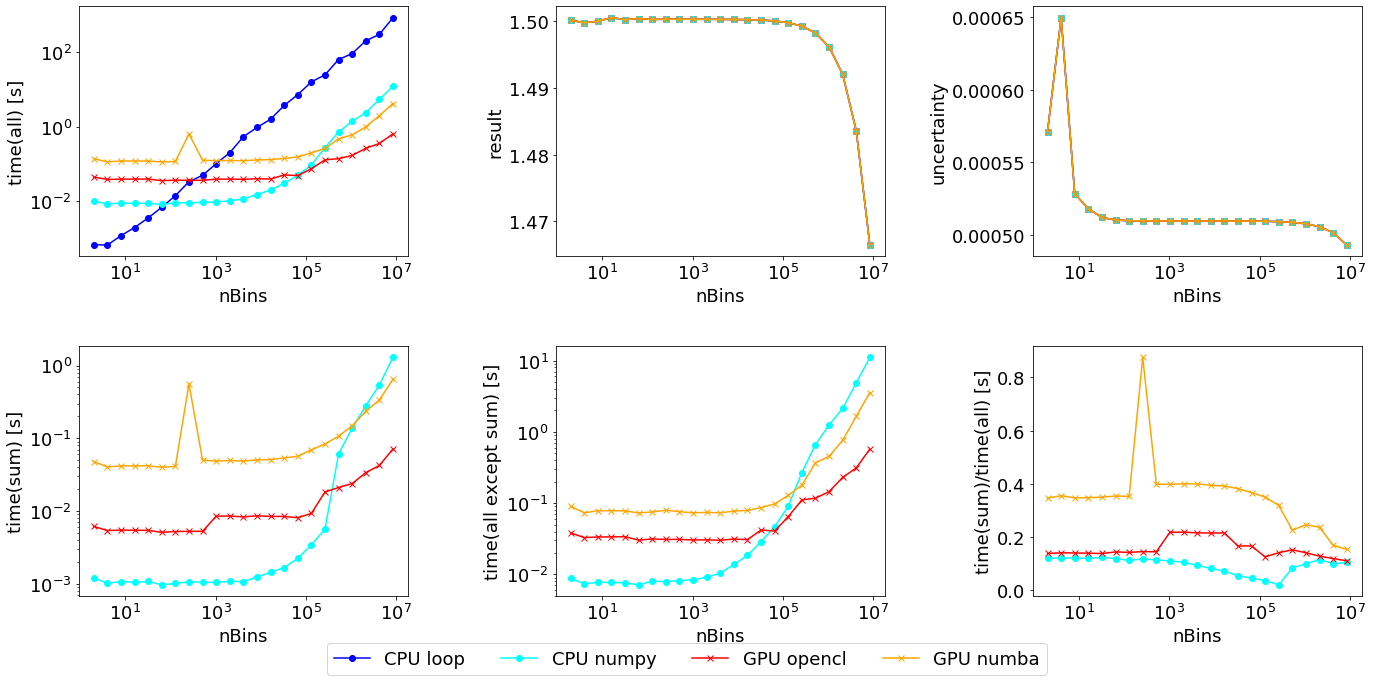

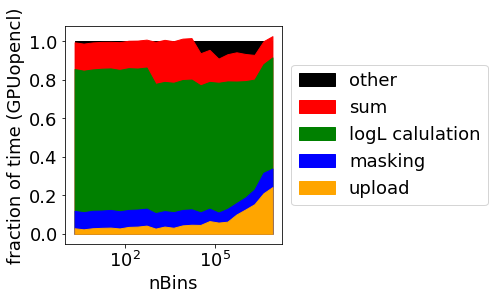

In [19]:
# perform migrad on CPU/GPU and measure the elapsed time
samplingBase = 2
samplingEndExponent = 23
sampling = np.power([samplingBase]*samplingEndExponent, range(1, samplingEndExponent + 1))
print('sampling:', sampling)

doTiming = True

for b in sampling:
    
    timeInSumCPUnumpy.append(0.)
    timeInSumGPUopencl.append(0.)
    timeInSumGPUcuda.append(0.)
    
    timeInUploadGPUopencl.append(0.)
    timeInMaskingGPUopencl.append(0.)
    timeInCalculationGPUopencl.append(0.)
                    
    _, data, sig, bkg, model = binMC(b)
 
    nBins.append(b)
    
    uploadDataGPUopencl()
    if usePyCuda: uploadDataGPUcuda()
    
    if usePyCuda:
        blockSize, gridSize = getBlockAndGridSize(data)    
        blockSizeGPU.append(blockSize)
        gridSizeGPU.append(gridSize)
    
    if doCPULoop: doMigrad(negLogLikelihoodCPUloop, timeCPUloop, resultCPUloop, uncertaintyCPUloop)
    doMigrad(negLogLikelihoodCPUnumpy, timeCPUnumpy, resultCPUnumpy, uncertaintyCPUnumpy)
    doMigrad(negLogLikelihoodGPUopencl, timeGPUopencl, resultGPUopencl, uncertaintyGPUopencl)
    doMigrad(negLogLikelihoodGPUcuda, timeGPUcuda, resultGPUcuda, uncertaintyGPUcuda)
    
    clear_output(wait=True)
    sys.stdout.write('\r'+ ' > nBins: ' + str(b) + ' of ' + str(sampling[-1]))
    
    if len(nBins) > 1:
        plot()
        plotTimeFractions()
        if usePyCuda: plotBlockAndGridSize()